In [67]:
# Normal libraries
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import hellinger_fidelity
import numpy as np
import matplotlib.pyplot as plt
# Noise libreries
from qiskit.providers.aer.noise import thermal_relaxation_error, NoiseModel
# Migitation libraries
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter, tensored_meas_cal, TensoredMeasFitter

# Information regarding to the problem:

For the noise simulation about $T_1$ and $T_2$ we need to fullfit the relation:
$$ T_2 \le 2T_1 $$

Comments: We need to put here a image refering to the problem to solve.

In [119]:
from qiskit.providers.aer import noise


def Qiskit_Fall_Fest(T1, T2, Shots):
    """
    Args:
    T1 : Value of relaxation time in microseconds.
    T2 : Value of dephasing time in microseconds.
    Shots: number of shots to simulate the quantum circuit.
    """

    # Definition of the circuit
    qr = QuantumRegister(3, 'qr')
    cr = ClassicalRegister(3, 'cr')

    qc = QuantumCircuit(qr,cr)
    qc.h(0)
    qc.cx(0,1)
    qc.cx(1,2)
    qc.measure(qr,cr)

    backend_noiseless = Aer.get_backend('qasm_simulator')
    job_noiseless = execute(qc, backend_noiseless , shots = Shots)
    result_noiseless = job_noiseless.result()
    counts_noiseless = result_noiseless.get_counts()

    # Definition of the noise simulation

    T1s = np.random.normal(T1*1e3, (T1*0.1)*1e3, 4)
    T2s = np.random.normal(T2*1e3, (T2*0.1)*1e3, 4)

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = time_u2*2 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                    for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                thermal_relaxation_error(t1b, t2b, time_cx))
                for t1a, t2a in zip(T1s, T2s)]
                for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(3):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

    backend_noise = Aer.get_backend('qasm_simulator')
    job_noise = execute(qc, backend=backend_noise, noise_model=noise_thermal, shots=Shots)
    result_noise = job_noise.result()
    counts_noise = result_noise.get_counts()

    # Mitigation Calculation

    qr_m = QuantumRegister(3)
    meas_calibs, state_labels = complete_meas_cal(qr=qr_m, circlabel='mcal')

    backend_mitigate = Aer.get_backend('qasm_simulator')
    job_mitigate = execute(meas_calibs, backend=backend_mitigate, shots=Shots, noise_model= noise_thermal)
    result_mitigate = job_mitigate.result()

    meas_fitter = CompleteMeasFitter(result_mitigate, state_labels, circlabel='mcal')
    meas_filter = meas_fitter.filter

    mitigated_results = meas_filter.apply(result_noise)
    mitigated_counts = mitigated_results.get_counts()

    ######## SPACE HERE FOR THE ERROR CORRECTION ###########

    qr_t = QuantumRegister(3)
    mit_pattern = [[1],[0,2]]
    meas_calibs_tensor, state_labels_tensor = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr_m, circlabel='mcal_tensor') 

    backend_tensor = Aer.get_backend('qasm_simulator')
    job_tensor = execute(meas_calibs, backend=backend_tensor, shots=Shots, noise_model = noise_thermal)
    cal_results_tensor = job_tensor.result()
    meas_fitter_tensor = TensoredMeasFitter(cal_results_tensor, mit_pattern=mit_pattern)

    meas_filter_tensor = meas_fitter_tensor.filter
    mitigated_results_tensor = meas_filter_tensor.apply(result_noise)
    mitigated_counts_tensor = mitigated_results_tensor.get_counts(0)

    #########################################

    qc_new = QuantumCircuit(5,3)
    qc_new.h(0)
    qc_new.cx(0,1)
    qc_new.cx(0,2)
    qc_new.cx(1,3)
    qc_new.cx(0,4)
    qc_new.cx(2,3)
    qc_new.cx(2,4)
    qc_new.barrier()
    qc_new.cx(4,0)
    qc_new.cx(3,1)
    qc_new.ccx(3,4,0)
    qc_new.ccx(3,4,1)
    qc_new.ccx(3,4,2)

    qc_new.measure([0,1,2],[0,1,2])

    backend_new = Aer.get_backend('qasm_simulator')
    job_new = execute(qc, backend=backend_new, noise_model=noise_thermal, shots=Shots)
    result_new = job_new.result()
    counts_new = result_new.get_counts()

    return counts_noiseless, counts_noise, mitigated_counts, mitigated_counts_tensor, counts_new

In [132]:
counts_noiseless, counts_noise, counts_mitigated, tensor, prueba = Qiskit_Fall_Fest(50,40,1000)

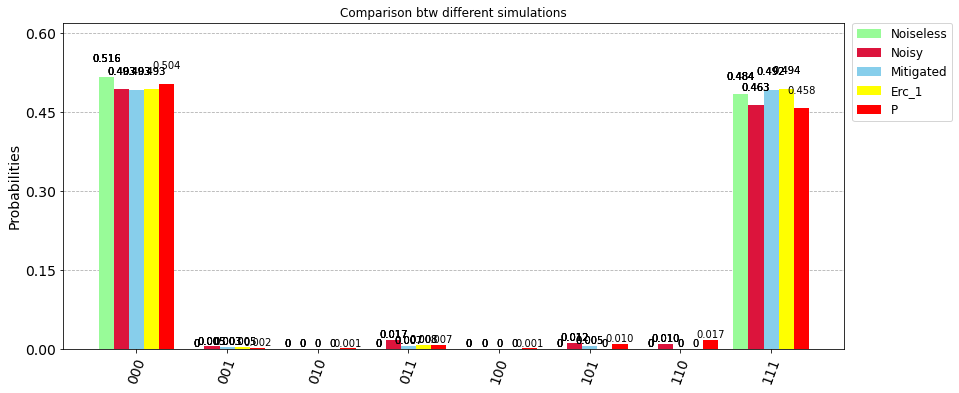

In [133]:
plot_histogram([counts_noiseless, counts_noise, counts_mitigated, tensor, prueba], 
    legend=['Noiseless','Noisy', 'Mitigated', 'Erc_1','P'],
    figsize=[14,6], title="Comparison btw different simulations", color=['palegreen','crimson','skyblue','yellow','red'])

In [134]:
# Calculate the fidelity in terms of the noise parameters.

# Changing only T1.
samples = np.linspace(1000,40,10)
Shots = 1000

fid_noiseless_noise = []
fid_noiseless_mitigate = []
fid_noiseless_erc_1 = []
fid_noiseless_erc_2 = []

for i in samples:
    noiseless, noise, mitigated, erc_1, p = Qiskit_Fall_Fest(i,50, Shots) 
    fid_noiseless_noise.append(hellinger_fidelity(noiseless, noise))
    fid_noiseless_mitigate.append(hellinger_fidelity(noiseless, mitigated))
    fid_noiseless_erc_1.append(hellinger_fidelity(noiseless, erc_1))
    fid_noiseless_erc_2.append(hellinger_fidelity(noiseless, p))

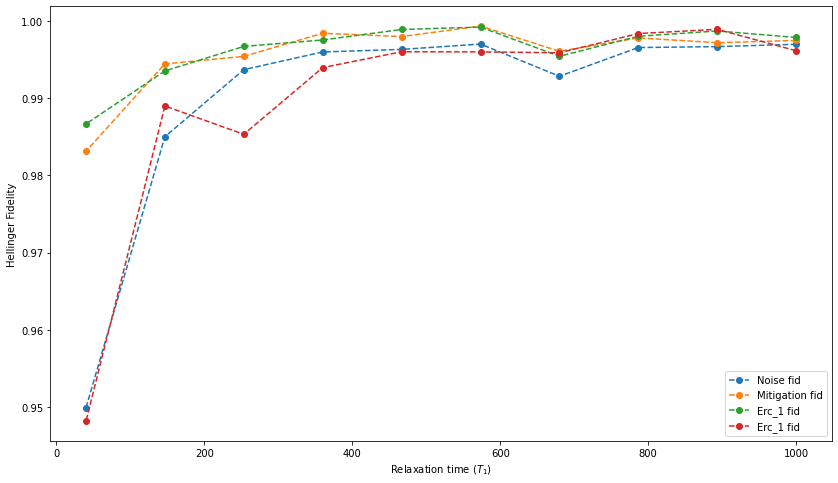

In [135]:
plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams['legend.fontsize'] = 10
plt.rcParams.update({'font.size': 10})

plt.plot(samples, fid_noiseless_noise,'o--', label="Noise fid")
plt.plot(samples,fid_noiseless_mitigate, 'o--', label='Mitigation fid')
plt.plot(samples,fid_noiseless_erc_1, 'o--', label='Erc_1 fid')
plt.plot(samples,fid_noiseless_erc_2, 'o--', label='Erc_1 fid')

plt.ylabel("Hellinger Fidelity")
plt.xlabel("Relaxation time ($T_1$)")
plt.legend()
plt.show()